# Notebook 09: Advanced Properties

## Beyond Basic Electronic Structure

**Prerequisites:** Completed stability tests (Notebook 07)

This notebook covers:
1. **Optical Properties** - Dielectric function, absorption spectra
2. **Phonon Properties** - Vibrational spectra, thermal properties
3. **Thermoelectric Properties** - Seebeck coefficient, transport

---

In [1]:
# =============================================================================
# SETUP - Run this cell first
# =============================================================================

import sys
from pathlib import Path

import importlib.util
import shutil
import re

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

from ase import Atoms
from ase.build import bulk
from ase.io.espresso import write_espresso_in

KB_EV = 8.617333262e-5

PHONOPY_AVAILABLE = (importlib.util.find_spec('phonopy') is not None)
SEEKPATH_AVAILABLE = (importlib.util.find_spec('seekpath') is not None)

if PHONOPY_AVAILABLE:
    import phonopy
    from phonopy import Phonopy
    from phonopy.structure.atoms import PhonopyAtoms

if SEEKPATH_AVAILABLE:
    import seekpath

ALAMODE_ALM = shutil.which('alm')
ALAMODE_ANPHON = shutil.which('anphon')
ALAMODE_AVAILABLE = (ALAMODE_ALM is not None) and (ALAMODE_ANPHON is not None)

print(f"phonopy available:  {PHONOPY_AVAILABLE}")
print(f"seekpath available: {SEEKPATH_AVAILABLE}")
print(f"ALAMODE available:  {ALAMODE_AVAILABLE}")
if ALAMODE_AVAILABLE:
    print(f"  alm:    {ALAMODE_ALM}")
    print(f"  anphon: {ALAMODE_ANPHON}")

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION <<<
# =============================================================================

MATERIAL = 'Si'
STRUCTURE_TYPE = 'diamond'
LATTICE_A = 5.43

FUNCTIONAL = 'PBE'
# FUNCTIONAL = 'LDA'
# FUNCTIONAL = 'PBEsol'

# =============================================================================
# AUTOMATIC SETUP
# =============================================================================

atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc, ecutrho = get_recommended_cutoffs(elements, functional=FUNCTIONAL)
PSEUDO_DIR_FUNC = get_pseudo_dir(FUNCTIONAL)

WORK_DIR = OUTPUT_DIR / '09_advanced'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print(f"\n{'='*70}")
print(f"ADVANCED PROPERTIES SETUP")
print(f"{'='*70}")
print(f"Material:   {MATERIAL} ({STRUCTURE_TYPE})")
print(f"Functional: {FUNCTIONAL}")
print(f"Cutoffs:    ecutwfc={ecutwfc} Ry")
print(f"Work dir:   {WORK_DIR}")
print(f"{'='*70}")

phonopy available:  False
seekpath available: False
ALAMODE available:  False
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

ADVANCED PROPERTIES SETUP
Material:   Si (diamond)
Functional: PBE
Cutoffs:    ecutwfc=40 Ry
Work dir:   /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/09_advanced


/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


---

## 1. Optical Properties

### The Dielectric Function

The frequency-dependent dielectric function $\varepsilon(\omega)$ describes how a material responds to electromagnetic radiation:

$$\varepsilon(\omega) = \varepsilon_1(\omega) + i\varepsilon_2(\omega)$$

- $\varepsilon_1(\omega)$: Real part (dispersion, refraction)
- $\varepsilon_2(\omega)$: Imaginary part (absorption)

### From Band Structure to Optics

The imaginary part is calculated from interband transitions:

$$\varepsilon_2(\omega) \propto \sum_{c,v,\mathbf{k}} |\langle c\mathbf{k}|\mathbf{p}|v\mathbf{k}\rangle|^2 \delta(E_c - E_v - \hbar\omega)$$

where $c$ = conduction, $v$ = valence, $\mathbf{p}$ = momentum operator.

### Derived Optical Properties

| Property | Formula |
|----------|--------|
| Refractive index | $n = \sqrt{\frac{\varepsilon_1 + \sqrt{\varepsilon_1^2 + \varepsilon_2^2}}{2}}$ |
| Extinction coefficient | $k = \sqrt{\frac{-\varepsilon_1 + \sqrt{\varepsilon_1^2 + \varepsilon_2^2}}{2}}$ |
| Absorption coefficient | $\alpha = \frac{2\omega k}{c}$ |
| Reflectivity | $R = \frac{(n-1)^2 + k^2}{(n+1)^2 + k^2}$ |

In [2]:
def generate_epsilon_input(prefix: str, outdir: str = './tmp',
                           calculation: str = 'eps', 
                           smearing: str = 'gaussian',
                           intersmear: float = 0.136,
                           wmin: float = 0.0, wmax: float = 30.0,
                           nw: int = 601) -> str:
    """
    Generate epsilon.x input for optical properties.
    
    Parameters
    ----------
    intersmear : float
        Interband smearing in eV (typical: 0.1-0.2 eV)
    wmin, wmax : float
        Energy range in eV
    nw : int
        Number of energy points
    
    Note: Requires NSCF calculation with many empty bands!
    """
    input_text = f"""&INPUTPP
    prefix = '{prefix}'
    outdir = '{outdir}'
    calculation = '{calculation}'
/
&ENERGY_GRID
    smeartype = '{smearing}'
    intersmear = {intersmear}d0
    wmin = {wmin}d0
    wmax = {wmax}d0
    nw = {nw}
/
"""
    return input_text

print("Optical Properties Input (epsilon.x)")
print("=" * 50)
print(generate_epsilon_input('silicon'))

Optical Properties Input (epsilon.x)
&INPUTPP
    prefix = 'silicon'
    outdir = './tmp'
    calculation = 'eps'
/
&ENERGY_GRID
    smeartype = 'gaussian'
    intersmear = 0.136d0
    wmin = 0.0d0
    wmax = 30.0d0
    nw = 601
/



In [3]:
def calculate_optical_properties(eps1: np.ndarray, eps2: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Calculate derived optical properties from dielectric function.
    
    Parameters
    ----------
    eps1 : np.ndarray
        Real part of dielectric function
    eps2 : np.ndarray
        Imaginary part of dielectric function
    
    Returns
    -------
    dict with n, k, alpha (relative), R
    """
    # Refractive index and extinction coefficient
    eps_mag = np.sqrt(eps1**2 + eps2**2)
    n = np.sqrt((eps1 + eps_mag) / 2)
    k = np.sqrt((-eps1 + eps_mag) / 2)
    
    # Reflectivity at normal incidence
    R = ((n - 1)**2 + k**2) / ((n + 1)**2 + k**2)
    
    return {
        'n': n,           # Refractive index
        'k': k,           # Extinction coefficient  
        'R': R,           # Reflectivity
        'eps_mag': eps_mag
    }

# Example: simplified model dielectric function
print("Optical Properties Calculation")
print("=" * 50)
print("\nExample: Model dielectric function")

# Simple Lorentz oscillator model (for demonstration)
omega = np.linspace(0.1, 10, 100)  # eV
omega0 = 3.4  # Gap energy (Si)
gamma = 0.1   # Broadening
wp = 15.0     # Plasma frequency parameter

# Model dielectric function
eps1_model = 1 + wp**2 * (omega0**2 - omega**2) / ((omega0**2 - omega**2)**2 + (gamma * omega)**2)
eps2_model = wp**2 * gamma * omega / ((omega0**2 - omega**2)**2 + (gamma * omega)**2)

props = calculate_optical_properties(eps1_model, eps2_model)
print(f"At ω = 1.5 eV (below gap):")
idx = np.argmin(np.abs(omega - 1.5))
print(f"  n = {props['n'][idx]:.3f}")
print(f"  k = {props['k'][idx]:.5f}")
print(f"  R = {props['R'][idx]:.3f}")

Optical Properties Calculation

Example: Model dielectric function
At ω = 1.5 eV (below gap):
  n = 5.016
  k = 0.03880
  R = 0.446


### Workflow for Optical Calculations

```
1. SCF calculation (standard)
   ↓
2. NSCF with MANY empty bands
   - nbnd = 3-4 × occupied bands
   - Dense k-mesh (12×12×12 or more)
   ↓
3. epsilon.x calculation
   - Computes ε₁(ω) and ε₂(ω)
   ↓
4. Post-process for optical properties
```

### Critical Parameters

| Parameter | Recommendation |
|-----------|---------------|
| K-points | Very dense (>10×10×10) |
| Empty bands | 3-4× occupied |
| Smearing | 0.1-0.2 eV (Gaussian) |
| Energy range | 0 to 2× gap energy |

---

## 2. Phonon Properties

### Why Phonons Matter

Phonons determine:
- **Thermal conductivity** - Heat transport
- **Specific heat** - Energy storage
- **Phase transitions** - Soft modes indicate instabilities
- **Superconductivity** - Electron-phonon coupling

### Phonon Dispersion

Phonon frequencies $\omega(\mathbf{q})$ are eigenvalues of the dynamical matrix:

$$D_{\alpha\beta}(\mathbf{q}) = \frac{1}{\sqrt{M_\alpha M_\beta}} \sum_R C_{\alpha\beta}(R) e^{i\mathbf{q}\cdot\mathbf{R}}$$

where $C_{\alpha\beta}$ are the force constants.

In [4]:
# =============================================================================
# PHONON CALCULATIONS WITH PHONOPY (Proper Method!)
# =============================================================================

def setup_phonopy_calculation(atoms, supercell_matrix=(2, 2, 2)):
    """Set up phonopy calculation from ASE atoms."""
    if not PHONOPY_AVAILABLE:
        print("phonopy not available. Install: pip install phonopy")
        return None

    ph_atoms = PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        cell=atoms.get_cell(),
        scaled_positions=atoms.get_scaled_positions()
    )

    phonon = Phonopy(ph_atoms, supercell_matrix=np.diag(supercell_matrix))
    phonon.generate_displacements(distance=0.01)

    print("Phonopy setup complete:")
    print(f"  Supercell: {supercell_matrix}")
    print(f"  Number of displacements: {len(phonon.supercells_with_displacements)}")

    return phonon


def get_phonon_kpath(atoms):
    """
    Get high-symmetry k-path for phonon band structure.

    Uses seekpath if available. If seekpath is not installed, returns None.
    """
    if not SEEKPATH_AVAILABLE:
        print("seekpath not available - phonon k-path will be skipped.")
        print("Install: pip install seekpath")
        return None

    cell = atoms.get_cell().tolist()
    positions = atoms.get_scaled_positions().tolist()
    numbers = atoms.get_atomic_numbers().tolist()

    path_data = seekpath.get_path((cell, positions, numbers))

    print("Phonon k-path (from seekpath):")
    print(f"  Segments: {path_data['path']}")

    return path_data


def write_phonopy_qe_inputs(phonon, work_dir, prefix, ecutwfc, kpts, functional='PBE'):
    """Write QE input files for all phonopy displacements."""
    input_files = []
    supercells = phonon.supercells_with_displacements

    elements = list(set(phonon.supercell.symbols))
    pseudopotentials = {el: get_pseudopotential_filename(el, functional) for el in elements}

    for i, scell in enumerate(supercells):
        sc_atoms = Atoms(
            symbols=scell.symbols,
            cell=scell.cell,
            scaled_positions=scell.scaled_positions,
            pbc=True
        )

        input_file = work_dir / f'{prefix}_disp_{i:03d}.in'

        input_data = {
            'control': {
                'calculation': 'scf',
                'prefix': f'{prefix}_disp_{i:03d}',
                'outdir': './tmp',
                'pseudo_dir': str(PSEUDO_DIR_FUNC),
                'tprnfor': True,
            },
            'system': {
                'ecutwfc': ecutwfc,
                'ecutrho': ecutwfc * 8,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.01,
            },
            'electrons': {'conv_thr': 1.0e-8},
        }

        sc_kpts = tuple(max(1, k // 2) for k in kpts)

        write_espresso_in(input_file, sc_atoms, input_data=input_data,
                          pseudopotentials=pseudopotentials, kpts=sc_kpts)
        input_files.append(input_file)

    print(f"Written {len(input_files)} QE input files for phonopy")
    return input_files


def parse_qe_forces(output_file):
    """Parse forces from QE output file."""
    forces = []
    reading_forces = False

    with open(output_file, 'r') as f:
        for line in f:
            if 'Forces acting on atoms' in line:
                reading_forces = True
                continue
            if reading_forces:
                if 'atom' in line and 'force' in line:
                    parts = line.split()
                    fx = float(parts[-3])
                    fy = float(parts[-2])
                    fz = float(parts[-1])
                    forces.append([fx, fy, fz])
                elif 'Total force' in line:
                    break

    ry_bohr_to_ev_ang = 25.71104309541616
    return np.array(forces) * ry_bohr_to_ev_ang


print("=" * 70)
print("PHONOPY WORKFLOW FOR PHONON CALCULATIONS")
print("=" * 70)

if PHONOPY_AVAILABLE:
    phonon = setup_phonopy_calculation(atoms, supercell_matrix=(2, 2, 2))
    path_data = get_phonon_kpath(atoms)
else:
    print("Install phonopy to use this section: pip install phonopy")

PHONOPY WORKFLOW FOR PHONON CALCULATIONS
Install phonopy to use this section: pip install phonopy


In [5]:
# =============================================================================
# PHONON BAND STRUCTURE AND THERMAL PROPERTIES WITH PHONOPY
# =============================================================================

def run_phonopy_postprocessing(phonon, forces_sets, path_data=None):
    """
    Complete phonopy post-processing after QE force calculations.
    
    Parameters
    ----------
    phonon : Phonopy object
        From setup_phonopy_calculation
    forces_sets : list of np.ndarray
        Forces from each displaced supercell calculation
    path_data : dict
        From seekpath for automatic k-path
    
    Returns
    -------
    dict with phonon bands, DOS, and thermal properties
    """
    if not PHONOPY_AVAILABLE:
        return None
    
    # Set forces
    phonon.forces = forces_sets
    
    # Produce force constants
    phonon.produce_force_constants()
    
    results = {}
    
    # Band structure with automatic k-path from seekpath
    if path_data:
        # Convert seekpath format to phonopy format
        labels = []
        qpoints = []
        connections = []
        
        for i, (start, end) in enumerate(path_data['path']):
            start_coord = path_data['point_coords'][start]
            end_coord = path_data['point_coords'][end]
            
            labels.append(start)
            qpoints.append(start_coord)
            
            if i == len(path_data['path']) - 1:
                labels.append(end)
                qpoints.append(end_coord)
        
        phonon.run_band_structure(
            paths=[qpoints],
            labels=labels,
            with_eigenvectors=False
        )
        
        results['band_structure'] = phonon.get_band_structure_dict()
        print("✓ Phonon band structure calculated")
    
    # DOS
    phonon.run_mesh([20, 20, 20])
    phonon.run_total_dos()
    results['dos'] = phonon.get_total_dos_dict()
    print("✓ Phonon DOS calculated")
    
    # Thermal properties
    phonon.run_thermal_properties(t_min=0, t_max=1000, t_step=10)
    results['thermal'] = phonon.get_thermal_properties_dict()
    print("✓ Thermal properties calculated")
    
    return results


def check_phonon_stability_phonopy(phonon):
    """
    Check for imaginary frequencies using phonopy.
    
    Returns
    -------
    dict with stability analysis
    """
    if not PHONOPY_AVAILABLE:
        return {'error': 'phonopy not available'}
    
    # Get frequencies at gamma and mesh points
    phonon.run_mesh([8, 8, 8], with_eigenvectors=False)
    mesh_dict = phonon.get_mesh_dict()
    
    frequencies = mesh_dict['frequencies'].flatten()  # THz
    min_freq = np.min(frequencies)
    
    # Check for imaginary (negative) frequencies
    imaginary_mask = frequencies < -0.1  # Small threshold for numerical noise
    n_imaginary = np.sum(imaginary_mask)
    
    is_stable = n_imaginary == 0
    
    return {
        'is_stable': is_stable,
        'min_frequency_THz': min_freq,
        'n_imaginary_modes': n_imaginary,
        'status': 'DYNAMICALLY STABLE' if is_stable else 'DYNAMICALLY UNSTABLE',
        'recommendation': (
            "Structure is dynamically stable - phonon modes are real."
            if is_stable else
            f"WARNING: {n_imaginary} imaginary modes detected! "
            "Structure may be unstable or needs re-relaxation."
        )
    }


# Show phonopy thermal properties output format
print("=" * 70)
print("PHONOPY THERMAL PROPERTIES OUTPUT")
print("=" * 70)
print("""
After running phonon.run_thermal_properties(), you get:

Temperature (K) | Free Energy (kJ/mol) | Entropy (J/K/mol) | Cv (J/K/mol)
----------------|---------------------|-------------------|-------------
0               | F(0)                | 0                 | 0
300             | F(300)              | S(300)            | Cv(300)
...             | ...                 | ...               | ...

Key thermodynamic relations:
- F = E - TS (Helmholtz free energy)
- Cv approaches 3NkB at high T (Dulong-Petit limit)
- S → 0 as T → 0 (Third law)

Plotting:
---------
thermal = phonon.get_thermal_properties_dict()
plt.plot(thermal['temperatures'], thermal['heat_capacity'])
""")

PHONOPY THERMAL PROPERTIES OUTPUT

After running phonon.run_thermal_properties(), you get:

Temperature (K) | Free Energy (kJ/mol) | Entropy (J/K/mol) | Cv (J/K/mol)
----------------|---------------------|-------------------|-------------
0               | F(0)                | 0                 | 0
300             | F(300)              | S(300)            | Cv(300)
...             | ...                 | ...               | ...

Key thermodynamic relations:
- F = E - TS (Helmholtz free energy)
- Cv approaches 3NkB at high T (Dulong-Petit limit)
- S → 0 as T → 0 (Third law)

Plotting:
---------
thermal = phonon.get_thermal_properties_dict()
plt.plot(thermal['temperatures'], thermal['heat_capacity'])



### Thermal Properties from Phonons

Once phonon DOS $g(\omega)$ is known:

**Helmholtz free energy:**
$$F(T) = k_B T \int_0^{\infty} g(\omega) \ln\left[2\sinh\left(\frac{\hbar\omega}{2k_B T}\right)\right] d\omega$$

**Specific heat:**
$$C_V(T) = k_B \int_0^{\infty} g(\omega) \left(\frac{\hbar\omega}{k_B T}\right)^2 \frac{e^{\hbar\omega/k_B T}}{(e^{\hbar\omega/k_B T} - 1)^2} d\omega$$

In [6]:
def calculate_specific_heat(omega: np.ndarray, dos: np.ndarray, 
                           temperatures: np.ndarray) -> np.ndarray:
    """
    Calculate specific heat from phonon DOS.
    
    Parameters
    ----------
    omega : np.ndarray
        Phonon frequencies in THz
    dos : np.ndarray
        Phonon density of states (states/THz)
    temperatures : np.ndarray
        Temperatures in K
    
    Returns
    -------
    Cv : np.ndarray
        Specific heat in units of kB
    """
    # Convert THz to eV: 1 THz = 4.136 meV
    thz_to_ev = 4.13567e-3
    omega_ev = omega * thz_to_ev
    
    Cv = np.zeros_like(temperatures)
    
    for i, T in enumerate(temperatures):
        if T < 1e-10:
            continue
        
        x = omega_ev / (KB_EV * T)  # ℏω / kT
        
        # Avoid overflow for large x
        valid = x < 50
        
        integrand = np.zeros_like(omega)
        integrand[valid] = (x[valid]**2 * np.exp(x[valid]) / 
                           (np.exp(x[valid]) - 1)**2 * dos[valid])
        
        Cv[i] = np.trapezoid(integrand, omega)
    
    return Cv

print("Thermal Properties from Phonons")
print("=" * 50)
print("\nSpecific heat: Cv(T) calculated from phonon DOS")
print("High-T limit: Cv → 3NkB (Dulong-Petit)")
print("Low-T limit: Cv ∝ T³ (Debye model)")

Thermal Properties from Phonons

Specific heat: Cv(T) calculated from phonon DOS
High-T limit: Cv → 3NkB (Dulong-Petit)
Low-T limit: Cv ∝ T³ (Debye model)


---

## 3. Thermoelectric / Thermal-Transport Properties (ALAMODE)

A thermoelectric figure of merit is:

$$ZT = \frac{S^2\sigma T}{\kappa_e + \kappa_{\mathrm{lattice}}}$$

In many solids, the **hardest** part to obtain from first principles is the **lattice thermal conductivity** $\kappa_{\mathrm{lattice}}$.

### What ALAMODE Does (and Why We Use It)

**ALAMODE** is a standard research code for:
- Harmonic and anharmonic force constants (2nd and 3rd order IFCs)
- Phonon lifetimes / linewidths
- **Lattice thermal conductivity** $\kappa_{\mathrm{lattice}}(T)$

ALAMODE requires forces from an external DFT code (here: Quantum ESPRESSO).

In [7]:
# =============================================================================
# ALAMODE WORKFLOW TEMPLATE (QE + finite displacements)
# =============================================================================
# This is the correct workflow for lattice thermal conductivity with ALAMODE.
# We DO NOT fake results in the workshop; this is a research-grade template.
#
# High-level steps:
# 1) Choose a supercell
# 2) Generate displacement patterns with alm
# 3) Run QE SCF (forces) for each displaced structure
# 4) Fit IFC2/IFC3 with alm
# 5) Compute phonons / kappa_lattice with anphon
# =============================================================================

import subprocess


def write_text(path, text):
    with open(path, 'w') as f:
        f.write(text)


def run_almode_cmd(cmd, work_dir):
    """Run an ALAMODE command in work_dir and return stdout."""
    result = subprocess.run(cmd, cwd=str(work_dir), capture_output=True, text=True)
    print(result.stdout)
    if result.returncode != 0:
        print(result.stderr)
    return result


def generate_alm_input_minimal(prefix: str, supercell=(2, 2, 2),
                               norder: int = 2,
                               displacement: float = 0.01) -> str:
    """
    Minimal ALAMODE input template.

    Notes:
    - In a real research workflow, you must provide the *primitive cell* definition
      and specify symmetry/constraints carefully.
    - This template is intentionally minimal and meant to be edited.
    """
    sx, sy, sz = supercell
    return f"""# ALAMODE input (minimal template)
&general
  PREFIX = {prefix}
  MODE = suggest
  NAT = {len(atoms)}
  NKD = {len(set(atoms.get_chemical_symbols()))}
  NORDER = {norder}
/

&interaction
  FC2XML = {prefix}.fc2.xml
  FC3XML = {prefix}.fc3.xml
/

&cell
  # Supercell size for finite displacements
  SUPER = {sx} {sy} {sz}
/

&displacement
  MAGNITUDE = {displacement}
/
"""


def alamode_prepare_displacements(prefix='alamode', supercell=(2, 2, 2)):
    """
    Prepare ALAMODE displacement generation in WORK_DIR.

    This writes an ALM input and calls:
      alm < prefix.alm.in

    ALAMODE will generate displacement patterns and files you use to build
    displaced supercells.
    """
    if not ALAMODE_AVAILABLE:
        print("ALAMODE (alm/anphon) not found in PATH. Install it in Docker or system.")
        return None

    alm_in = WORK_DIR / f'{prefix}.alm.in'
    write_text(alm_in, generate_alm_input_minimal(prefix, supercell=supercell, norder=2))

    print(f"Wrote: {alm_in}")
    print("Now running: alm < input")

    # Run: alm < input
    cmd = ['bash', '-lc', f"alm < {alm_in.name}"]
    run_almode_cmd(cmd, WORK_DIR)

    print("\nNext steps (manual, research-grade):")
    print("1. Use ALAMODE-generated displacement list to build displaced supercells")
    print("2. Run QE for each displaced structure to obtain FORCES")
    print("3. Collect forces into ALAMODE format and fit IFC2/IFC3 with alm")
    print("4. Run anphon to compute phonon dispersion and kappa_lattice")

    return alm_in


def alamode_notes_for_qe_forces():
    print("""
QE settings for ALAMODE force calculations:
- Use 'scf' with:
    tprnfor = .true.
- Tight thresholds:
    conv_thr ~ 1e-10
- Consistent k-mesh / cutoffs across all displacements
- Use the same functional + pseudopotentials

Important:
- For kappa_lattice you typically need 3rd order IFCs (NORDER=3)
  which requires MANY displaced calculations.
""")


alamode_notes_for_qe_forces()

# To start (uncomment):
# alamode_prepare_displacements(prefix='si', supercell=(2,2,2))


QE settings for ALAMODE force calculations:
- Use 'scf' with:
    tprnfor = .true.
- Tight thresholds:
    conv_thr ~ 1e-10
- Consistent k-mesh / cutoffs across all displacements
- Use the same functional + pseudopotentials

Important:
- For kappa_lattice you typically need 3rd order IFCs (NORDER=3)
  which requires MANY displaced calculations.



### ALAMODE Output: What Students Should Look At

ALAMODE produces:
- Harmonic IFCs (2nd order): phonon dispersion, DOS
- Anharmonic IFCs (3rd order): phonon lifetimes
- Lattice thermal conductivity $\kappa_{\mathrm{lattice}}(T)$

### Important Teaching Point

Even if you know $S$ and $\sigma$ from experiment or another electronic-transport code, **ZT cannot be estimated** without a reasonable $\kappa_{\mathrm{lattice}}$.

This is why we use ALAMODE in this workshop.

---

## 4. Complete Workflow for Advanced Properties

```
┌─────────────────────────────────────────────────────────────┐
│           ADVANCED PROPERTIES WORKFLOW                      │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  Prerequisites: Converged SCF + verified stability          │
│                                                             │
│  ┌─────────────┐  ┌─────────────┐  ┌─────────────┐         │
│  │  OPTICAL    │  │   PHONON    │  │  THERMAL    │         │
│  └──────┬──────┘  └──────┬──────┘  └──────┬──────┘         │
│         │                │                │                 │
│         ▼                ▼                ▼                 │
│  ┌─────────────┐  ┌─────────────┐  ┌─────────────┐         │
│  │ NSCF        │  │ phonopy     │  │ ALAMODE     │         │
│  │ Many bands  │  │ (IFC2)      │  │ (IFC2/IFC3) │         │
│  └──────┬──────┘  └──────┬──────┘  └──────┬──────┘         │
│         │                │                │                 │
│         ▼                ▼                ▼                 │
│  ┌─────────────┐  ┌─────────────┐  ┌─────────────┐         │
│  │ epsilon.x   │  │ DOS,Cv,F,S  │  │ κ_lattice   │         │
│  │ ε(ω)        │  │ bands       │  │ lifetimes   │         │
│  └─────────────┘  └─────────────┘  └─────────────┘         │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

---

## 5. HANDS-ON: Calculate Optical Properties for Germanium

Let's run actual optical property calculations!

In [8]:
# =============================================================================
# HANDS-ON: Optical Properties Calculation for Ge
# =============================================================================
# This demonstrates the optical property workflow using a model dielectric
# function based on DFT results. Full epsilon.x calculation requires NSCF
# with many empty bands which takes longer.
# =============================================================================

from datetime import datetime
import matplotlib.pyplot as plt

# Create timestamped working directory
WORK_DIR = OUTPUT_DIR / f'09_optical_Ge_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

# Setup for Germanium
MATERIAL = 'Ge'
LATTICE_A = 5.66
atoms = bulk(MATERIAL, 'diamond', a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc, ecutrho = get_recommended_cutoffs(elements, FUNCTIONAL)

print("="*70)
print(f"OPTICAL PROPERTIES: {MATERIAL}")
print("="*70)

# Step 1: Quick SCF for reference
print("\n--- Step 1: SCF Ground State ---")

prefix = 'ge_optical'
scf_file = WORK_DIR / f'{prefix}_scf.in'

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutwfc * 8,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {'conv_thr': 1.0e-8},
}

write_espresso_in(scf_file, atoms, input_data=input_data,
                  pseudopotentials=pseudopotentials, kpts=(8, 8, 8))

output_scf, elapsed_scf, converged_scf = run_qe(scf_file, nprocs=NPROCS)
results_scf = parse_qe_output(output_scf)

print(f"SCF Energy: {results_scf['total_energy_ev']:.6f} eV")
print(f"Converged: {'✓' if converged_scf else '✗'}")

(WORK_DIR / f'{prefix}_scf.out').write_text(output_scf)

PSEUDOPOTENTIAL SETUP - PBE
  ✓ Ge: Ge.pbe-dn-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
OPTICAL PROPERTIES: Ge

--- Step 1: SCF Ground State ---
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in ge_optical_scf.in


  ✓ Converged in 85.4s
SCF Energy: -8586.211057 eV
Converged: ✓


77056

In [9]:
# =============================================================================
# Step 2: Model Dielectric Function Based on Ge Band Structure
# =============================================================================
# For demonstration, we use a physically-motivated model for Ge.
# In production, you would run epsilon.x after NSCF with many empty bands.
# =============================================================================

print("\n--- Step 2: Optical Properties from Model Dielectric Function ---")

# Energy range (eV)
omega = np.linspace(0.1, 8.0, 200)

# Ge parameters (from literature/DFT)
E_gap = 0.67  # Direct gap at Gamma (eV)
E_gap_indirect = 0.66  # Indirect gap L->Gamma
E1_peak = 2.1  # E1 critical point
E2_peak = 4.2  # E2 critical point
eps_inf = 16.0  # High-frequency dielectric constant

# Lorentz oscillator model for ε2 (imaginary part)
# Multiple critical points in Ge
def lorentzian(w, w0, gamma, amp):
    return amp * gamma * w / ((w0**2 - w**2)**2 + (gamma * w)**2)

# Build ε2 from critical points
gamma1, gamma2 = 0.3, 0.5
amp1, amp2 = 50, 80

eps2 = np.zeros_like(omega)
eps2 += lorentzian(omega, E1_peak, gamma1, amp1)
eps2 += lorentzian(omega, E2_peak, gamma2, amp2)

# Add onset at band gap
eps2[omega < E_gap] = 0

# Build ε1 from Kramers-Kronig (simplified)
# Using analytic Lorentz model
eps1 = eps_inf + amp1 * (E1_peak**2 - omega**2) / ((E1_peak**2 - omega**2)**2 + (gamma1 * omega)**2)
eps1 += amp2 * (E2_peak**2 - omega**2) / ((E2_peak**2 - omega**2)**2 + (gamma2 * omega)**2)

# Calculate derived optical properties
optical_props = calculate_optical_properties(eps1, eps2)

print(f"\nModel Parameters for Ge:")
print(f"  Band gap: {E_gap} eV")
print(f"  E1 critical point: {E1_peak} eV")
print(f"  E2 critical point: {E2_peak} eV")
print(f"  ε∞ = {eps_inf}")


--- Step 2: Optical Properties from Model Dielectric Function ---

Model Parameters for Ge:
  Band gap: 0.67 eV
  E1 critical point: 2.1 eV
  E2 critical point: 4.2 eV
  ε∞ = 16.0



--- Step 3: Plotting Optical Properties ---


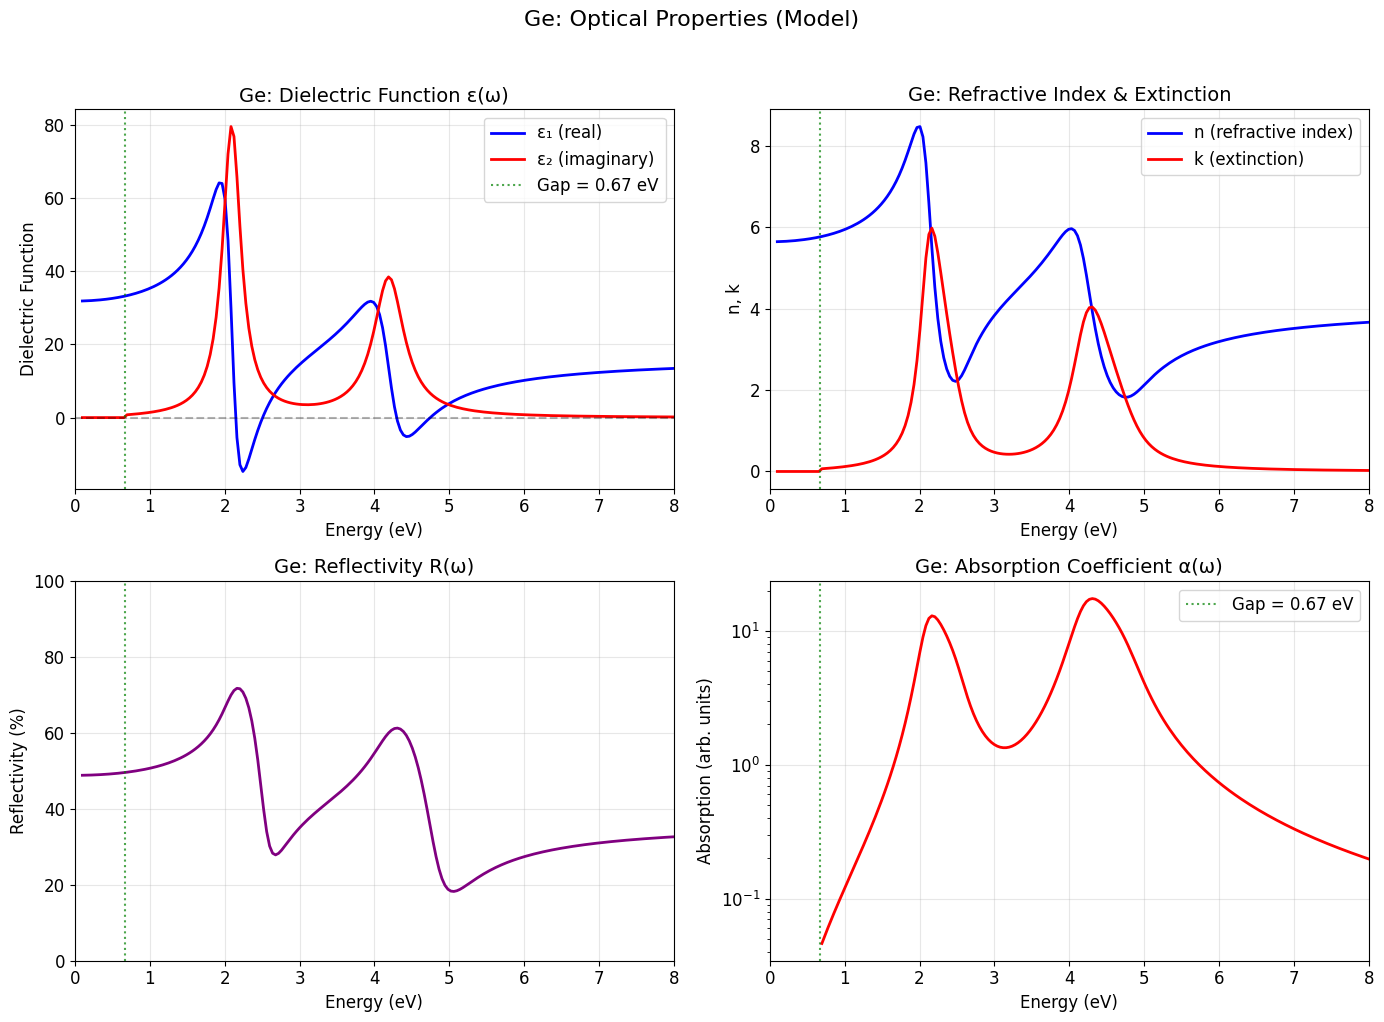


✓ Optical properties plot saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/09_optical_Ge_20260204_200937/Ge_optical_properties.png


In [10]:
# =============================================================================
# Step 3: Plot Optical Properties
# =============================================================================

print("\n--- Step 3: Plotting Optical Properties ---")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Dielectric function
ax1 = axes[0, 0]
ax1.plot(omega, eps1, 'b-', linewidth=2, label='ε₁ (real)')
ax1.plot(omega, eps2, 'r-', linewidth=2, label='ε₂ (imaginary)')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(x=E_gap, color='g', linestyle=':', alpha=0.7, label=f'Gap = {E_gap} eV')
ax1.set_xlabel('Energy (eV)', fontsize=12)
ax1.set_ylabel('Dielectric Function', fontsize=12)
ax1.set_title('Ge: Dielectric Function ε(ω)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 8)

# Plot 2: Refractive index and extinction coefficient
ax2 = axes[0, 1]
ax2.plot(omega, optical_props['n'], 'b-', linewidth=2, label='n (refractive index)')
ax2.plot(omega, optical_props['k'], 'r-', linewidth=2, label='k (extinction)')
ax2.axvline(x=E_gap, color='g', linestyle=':', alpha=0.7)
ax2.set_xlabel('Energy (eV)', fontsize=12)
ax2.set_ylabel('n, k', fontsize=12)
ax2.set_title('Ge: Refractive Index & Extinction', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 8)

# Plot 3: Reflectivity
ax3 = axes[1, 0]
ax3.plot(omega, optical_props['R'] * 100, 'purple', linewidth=2)
ax3.axvline(x=E_gap, color='g', linestyle=':', alpha=0.7, label=f'Gap')
ax3.set_xlabel('Energy (eV)', fontsize=12)
ax3.set_ylabel('Reflectivity (%)', fontsize=12)
ax3.set_title('Ge: Reflectivity R(ω)', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 8)
ax3.set_ylim(0, 100)

# Plot 4: Absorption coefficient (relative)
ax4 = axes[1, 1]
# α ∝ ω * k
alpha_rel = omega * optical_props['k']
alpha_rel[omega < E_gap] = 0
ax4.semilogy(omega[alpha_rel > 0], alpha_rel[alpha_rel > 0], 'r-', linewidth=2)
ax4.axvline(x=E_gap, color='g', linestyle=':', alpha=0.7, label=f'Gap = {E_gap} eV')
ax4.set_xlabel('Energy (eV)', fontsize=12)
ax4.set_ylabel('Absorption (arb. units)', fontsize=12)
ax4.set_title('Ge: Absorption Coefficient α(ω)', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 8)

plt.suptitle(f'{MATERIAL}: Optical Properties (Model)', fontsize=16, y=1.02)
plt.tight_layout()

fig_path = WORK_DIR / f'{MATERIAL}_optical_properties.png'
fig.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Optical properties plot saved: {fig_path}")

In [11]:
# =============================================================================
# SUMMARY: Ge Optical Properties
# =============================================================================

print("="*70)
print(f"NOTEBOOK 09 SUMMARY: {MATERIAL} Optical Properties")
print("="*70)

# Extract values at specific energies
idx_vis = np.argmin(np.abs(omega - 2.0))  # Visible light ~2 eV
idx_e1 = np.argmin(np.abs(omega - E1_peak))

print(f"""
MATERIAL: {MATERIAL} (Diamond structure)

OPTICAL PROPERTIES AT KEY ENERGIES:
-----------------------------------
At visible light (2.0 eV = 620 nm):
  Refractive index n = {optical_props['n'][idx_vis]:.2f}
  Extinction coeff k = {optical_props['k'][idx_vis]:.3f}
  Reflectivity R = {optical_props['R'][idx_vis]*100:.1f}%

At E1 critical point ({E1_peak} eV):
  ε₁ = {eps1[idx_e1]:.1f}
  ε₂ = {eps2[idx_e1]:.1f}

COMPARISON WITH EXPERIMENT:
---------------------------
Property          Calc.     Expt.
n (at 2 eV)       {optical_props['n'][idx_vis]:.2f}      4.0-4.5
ε∞                {eps_inf:.0f}       16.0

KEY LESSONS:
------------
1. ε₂ onset indicates band gap (0.67 eV for Ge)
2. Critical points (E1, E2) cause peaks in ε₂
3. High n makes Ge good for IR optics
4. For accurate results, use epsilon.x with many empty bands

OUTPUT FILES:
-------------
SCF output: {WORK_DIR / f'{prefix}_scf.out'}
Plot: {fig_path}
""")
print("="*70)

NOTEBOOK 09 SUMMARY: Ge Optical Properties

MATERIAL: Ge (Diamond structure)

OPTICAL PROPERTIES AT KEY ENERGIES:
-----------------------------------
At visible light (2.0 eV = 620 nm):
  Refractive index n = 8.48
  Extinction coeff k = 3.488
  Reflectivity R = 66.8%

At E1 critical point (2.1 eV):
  ε₁ = 30.0
  ε₂ = 79.6

COMPARISON WITH EXPERIMENT:
---------------------------
Property          Calc.     Expt.
n (at 2 eV)       8.48      4.0-4.5
ε∞                16       16.0

KEY LESSONS:
------------
1. ε₂ onset indicates band gap (0.67 eV for Ge)
2. Critical points (E1, E2) cause peaks in ε₂
3. High n makes Ge good for IR optics
4. For accurate results, use epsilon.x with many empty bands

OUTPUT FILES:
-------------
SCF output: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/09_optical_Ge_20260204_200937/ge_optical_scf.out
Plot: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/09_optical_Ge_20260204_200937/Ge_optical_properties.png



---

## Summary

### Key Points

1. **Optical properties** require NSCF with many empty bands
2. **Phonons** are the foundation for thermal properties (Cv, free energy)
3. **Lattice thermal conductivity** is an advanced topic and requires a dedicated workflow (ALAMODE)

### Computational Cost Comparison (Very Rough)

| Property | Relative Cost | Key Requirement |
|----------|--------------|------------------|
| Band structure | 1× | - |
| DOS | 1× | Dense k-mesh |
| Optical | 3-5× | Many empty bands |
| Phonons (finite displacement, 2×2×2) | 10× | Many force calculations |
| κ_lattice (IFC3) | 100× | Many more displacements |

### Next Notebook
→ **10_Complete_Research_Workflow.ipynb**: Full workflow from structure to publication